In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import cvxpy as cp
import matplotlib.pyplot as plt
import pickle
import copy
import libpysal
from toolz import curry, partial
from scipy.linalg import block_diag
from functions_ssdid import fit_time_weights, calculate_regularization, fit_unit_weights, join_weights


# 1 Read and clean data

In [2]:
#Unemployment rate at state level
df=pd.read_csv('./Data/state_unemployment.csv')
#df.head()

In [3]:
#Spatial weights matrix
wq=libpysal.io.open("./Data/US_no_islands_matrix.gal").read()
wq.transform = 'r' #row standardize it
#Extract matrix in array format
W1, idsa=wq.full() #Arizona
#List with states included
FIPS=wq.id_order
FIPS = [int(i) for i in FIPS] #Convert to numeric

In [4]:
#Restrict original dataset
data0=df[df['FIPS'].isin(FIPS)]
# The county of Los Angeles has the same FIPS code of North Carolina. Drop it
data0=data0[data0['State']!='Los Angeles County']
#Sort with the same order of the spatial matrix
data0['FIPS']=pd.Categorical(data0['FIPS'],categories=FIPS, ordered=True )
data0=data0.sort_values(by=['year','month','FIPS']).reset_index()
data0.rename(columns={"FIPS": "ID"}, inplace=True)
data0['ID']=data0['ID'].astype(int)

In [5]:
#Restrict a window of time
data=data0[(data0['year']>2010)&(data0['year']<2014)]
data['month']=np.repeat(np.arange(1,37),len(data['ID'].unique()))#Change the format of month column
data.shape

(1764, 12)

- Restricted data contains 36 monthly observations for unemployment rate at state level.
- We include an intervention (and a post-treatment effect) for ONE SINGLE STATE each time by the end of the second year
- The effect will spill over to the first-order neighbors according to a given spatial autoregressive parameter
- The Average Treatment on the Treated (ATT) is estimated using SDID and SSDID
- The Average Treatment Effect is estimated using SSDID

In [6]:
data['treatment']=False
data['after_treatment']=False
data.loc[data['year']==2013, 'after_treatment']=True

In [7]:
W=block_diag(*[W1]*36)
data.loc[data['ID']==5, 'treatment']=True #Arkansas
data['interaction']=data['after_treatment']*data['treatment'] #Create interaction variable
data['spillover']=W.dot(data['interaction'])

In [8]:
#Include the effects
ATT=data['perc_unem'].mean()/4 #ATT of 25%
#Direct effect
data['UR']=data['perc_unem']+data['interaction']*ATT
#Indirect effect (spillover)
rho=0.8
WD=data[data['spillover']>0]['spillover'].mean() #average proportion of treated neighbors
AITE=ATT*rho*WD
data['UR2']=data['UR']+data['spillover']*ATT*rho
data.tail()

,index,ID,State,year,month,civilian,total,percent,total_emp,perc_emp,total_unem,perc_unem,treatment,after_treatment,interaction,spillover,UR,UR2
22339,24124,11,District of Columbia,2013,36,543241,374139,68.9,344093,63.3,30046,8.0,False,True,False,0.0,8.0,8.0
22340,24129,17,Illinois,2013,36,10040361,6537549,65.1,5978331,59.5,559218,8.6,False,True,False,0.0,8.6,8.6
22341,24117,4,Arizona,2013,36,5127350,3076382,60.0,2850146,55.6,226236,7.4,False,True,False,0.0,7.4,7.4
22342,24144,32,Nevada,2013,36,2171241,1372217,63.2,1247354,57.4,124863,9.1,False,True,False,0.0,9.1,9.1
22343,24119,6,California,2013,36,29783733,18554149,62.3,17001882,57.1,1552267,8.4,False,True,False,0.0,8.4,8.4


**SUMMARIZING**

- ``perc_unem`` is the original variable
- ``UR`` is modified and contains the fake direct treatment effect
- ``UR2`` contains the direct and indirect effect

# 3 Estimating the effects

## 3.1 Estimate the ATT via Synthetic Diff-in-diff

In [9]:
#### RESTRICT DONOR POOL EXCLUDING POSSIBLE INDIRECTLY AFFECTED UNITS
affected=data[(data['spillover']>0)& (data['treatment']==False)] #Get the indirectly affected units at post-treatment periods
affected=data[data['ID'].isin(affected['ID'].unique())] #Dataframe with indirectly affected units for all time
data1=data[~data['ID'].isin(affected['ID'].unique())] #Dataframe with pure controls+treated unit

In [10]:
#####FIT WEIGHTS#####
time_weights = fit_time_weights(data1,outcome_col="UR2",year_col="month",
                            state_col="ID",treat_col="treatment",post_col="after_treatment")
unit_weights = fit_unit_weights(data1,outcome_col="UR2",year_col="month",
                            state_col="ID",treat_col="treatment",post_col="after_treatment")       

did_data = join_weights(data1, unit_weights, time_weights,year_col="month",
                    state_col="ID",treat_col="treatment",post_col="after_treatment")


In [11]:
###Estimate Synth DID
X=did_data[['treatment','after_treatment','interaction']]
Y=did_data['UR2']
X=sm.add_constant(X) #adding constant
X=X.replace([False,True],[0,1])
mod2 = sm.WLS(Y, X,weights=did_data["weights"]+1e-5).fit() 
print(mod2.summary().tables[1])
print( 'The ATT is', round(ATT,3), 'and the estimated value is',round(mod2.params[3],3 ))

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.8645      0.106     64.818      0.000       6.657       7.072
treatment           0.3394      0.702      0.483      0.629      -1.038       1.717
after_treatment    -0.3549      0.119     -2.995      0.003      -0.587      -0.122
interaction         2.0503      0.786      2.608      0.009       0.508       3.592
The ATT is 1.858 and the estimated value is 2.05


In [12]:
att_synth = []
att_SSDID = []
aite_SSDID = []
att_DELGADO = []
est_AITE_DELGADO = []
#--
att_synth_pct = []
att_SSDID_pct = []
aite_SSDID_pct = []
att_DELGADO_pct = []
est_AITE_DELGADO_pct = []
#--
pvalue=[]
for j in range (1975,2015):
    
    #del data
    data=data0[(data0['year']>j)&(data0['year']<j+4)]
    data['month']=np.repeat(np.arange(1,37),len(data['ID'].unique()))#Change the format of month column
    data['treatment']=False
    data['after_treatment']=False
    data.loc[data['year']==j+3, 'after_treatment']=True
    for i in data['ID'].unique():
        data['treatment']=False
        data.loc[data['ID']==i, 'treatment']=True 
        data['interaction']=data['after_treatment']*data['treatment'] #Create interaction variable
        data['spillover']=W.dot(data['interaction'])

        #Direct effect
        data['UR']=data['perc_unem']+data['interaction']*ATT

        #Indirect effect (spillover)
        WD=data[data['spillover']>0]['spillover'].mean() #average proportion of treated neighbors
        AITE=ATT*rho*WD
        data['UR2']=data['UR']+data['spillover']*ATT*rho

        #### RESTRICT DONOR POOL EXCLUDING INDIRECTLY AFFECTED UNITS
        affected=data[(data['spillover']>0)& (data['treatment']==False)] 
        affected=data[data['ID'].isin(affected['ID'].unique())] 
        data1=data[~data['ID'].isin(affected['ID'].unique())] 

        #####FIT WEIGHTS#####
        time_weights = fit_time_weights(data1,outcome_col="UR2",year_col="month",
                                    state_col="ID",treat_col="treatment",post_col="after_treatment")
        unit_weights = fit_unit_weights(data1,outcome_col="UR2",year_col="month",
                                    state_col="ID",treat_col="treatment",post_col="after_treatment")       

        did_data = join_weights(data1, unit_weights, time_weights,year_col="month",
                            state_col="ID",treat_col="treatment",post_col="after_treatment")
        
        ###Estimate Synth DID
        X=did_data[['treatment','after_treatment','interaction']]
        Y=did_data['UR2']
        X=sm.add_constant(X) #adding constant
        X=X.replace([False,True],[0,1])
        try:
            mod2 = sm.WLS(Y, X,weights=did_data["weights"]+1e-5).fit()
        except:
            mod2 = sm.WLS(Y, X,weights=did_data["weights"]+1e-4).fit()
            print('convergence problem')

        #Store result
        att_synth.append(ATT-mod2.params[3])
        
        ##### SPATIAL SYNTHETIC DIFF IN DIFF
        ###INCLUDE INDIRECTLY AFFECTED UNITS BACK
        affected=affected.assign(unit_weights=did_data[did_data['treatment']==1]['unit_weights'].mean())
        time_weights_complete=did_data.groupby('month').mean(numeric_only = True)['time_weights'].to_frame().reset_index()
        affected=pd.merge(affected, time_weights_complete, left_on='month', right_on='month')
        did_data2=pd.concat([did_data,affected]).sort_values(['month','ID'])
        did_data2['weights']=round(did_data2['unit_weights']*did_data2['time_weights'],10)

        #LSDV APPROACH
        new_df=pd.concat([pd.get_dummies(did_data2['ID'], prefix='ID'),pd.get_dummies(did_data2['month'], prefix='month'), did_data2],axis=1)
        Y=new_df['UR2']
        n=len(new_df['ID'].unique())
        t=36
        X=pd.concat([new_df[['interaction','spillover']],new_df.iloc[:,1:n+t-1] ],axis=1)
        X=sm.add_constant(X) #adding constant
        X=X.replace([False,True],[0,1])
        try:
            model2=sm.WLS(Y, X, weights=did_data2['weights']+1e-5).fit()
        except:
            #print('convergence problem2')
            model2=sm.WLS(Y, X, weights=did_data2['weights']+1e-4).fit()

        #Point estimates
        est_ATT_SSDID=model2.params[1]
        est_AITE_SSDID=model2.params[2]*WD
                
        #Store results (bias of each estimator)
        pvalue.append(model2.pvalues[2])
        att_DELGADO.append(ATT-sm.OLS(Y,X).fit().params[1])
        est_AITE_DELGADO.append(AITE-sm.OLS(Y,X).fit().params[2]*WD)
        att_SSDID.append(ATT-est_ATT_SSDID) # ATT bias from SSDID
        aite_SSDID.append(AITE-est_AITE_SSDID) # AITE bias from SSDID

        #--Results as percentage of true value
        att_synth_pct.append((ATT-mod2.params[3])/ATT)
        att_SSDID_pct.append((ATT-est_ATT_SSDID)/ATT)
        aite_SSDID_pct.append((AITE-est_AITE_SSDID)/AITE)
        att_DELGADO_pct.append((ATT-sm.OLS(Y,X).fit().params[1])/ATT)
        est_AITE_DELGADO_pct.append((AITE-sm.OLS(Y,X).fit().params[2]*WD)/AITE)
        #--
    print(j)

1975
1976
convergence problem
convergence problem2
1977
1978
1979
1980
convergence problem
convergence problem2
1981
1982
1983
1984
1985
convergence problem
convergence problem2
1986
1987
1988
convergence problem
convergence problem2
1989
1990
1991
1992
1993
1994
convergence problem
convergence problem2
1995
1996
convergence problem
convergence problem2
1997
1998
1999
2000
2001
convergence problem
convergence problem2
2002
2003
convergence problem
convergence problem2
2004
2005
convergence problem
convergence problem2
2006
2007
convergence problem
convergence problem2
2008
2009
2010
convergence problem
convergence problem2
2011
convergence problem
convergence problem2
2012
2013
2014


# 4 Results

## 4.1 Bias (Tables 4 and 5)

In [13]:
desc=pd.DataFrame({'att_synth':att_synth, 'att_SSDID':att_SSDID, 'aite_SSDID':aite_SSDID,
                   'aite_DELGADO':est_AITE_DELGADO, 'att_DELGADO':att_DELGADO,
                   'att_synth_pct':  att_synth_pct, 'att_SSDID_pct':att_SSDID_pct, 'aite_SSDID_pct':aite_SSDID_pct,
                   'aite_DELGADO_pct':est_AITE_DELGADO_pct, 'att_DELGADO_pct':att_DELGADO_pct,                  
                       'p':pvalue}).describe()

In [14]:
desc.round(3)

,att_synth,att_SSDID,aite_SSDID,aite_DELGADO,att_DELGADO,att_synth_pct,att_SSDID_pct,aite_SSDID_pct,aite_DELGADO_pct,att_DELGADO_pct,p
count,1960.000,1960.000,1960.000,1960.000,1960.000,1960.000,1960.000,1960.000,1960.000,1960.000,1960.000
mean,0.007,0.007,0.005,-0.002,-0.001,0.004,0.004,0.010,-0.020,-0.000,0.042
std,0.362,0.362,0.231,0.473,0.713,0.195,0.195,0.738,1.486,0.384,0.150
min,-1.745,-1.742,-0.973,-2.353,-4.023,-0.940,-0.938,-3.461,-7.895,-2.165,0.000
25%,-0.211,-0.212,-0.130,-0.236,-0.401,-0.114,-0.114,-0.411,-0.754,-0.216,0.000
50%,-0.001,0.000,0.002,0.008,0.023,-0.001,0.000,0.006,0.024,0.012,0.000
75%,0.220,0.219,0.140,0.266,0.420,0.118,0.118,0.415,0.798,0.226,0.000
max,1.901,1.893,0.899,1.727,3.252,1.023,1.019,3.300,5.646,1.751,0.998


## 4.2 Disribution of errors (Figures 4 and 5)

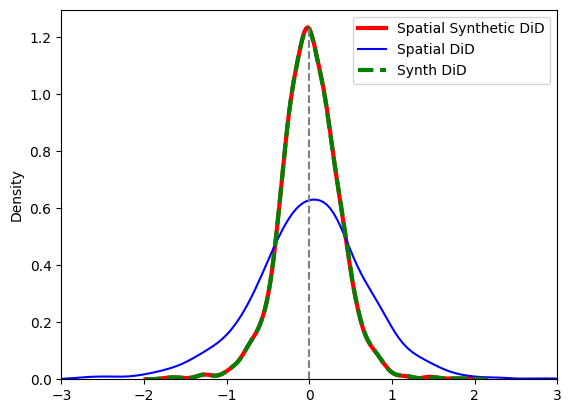

In [15]:
#sns.kdeplot(att_synth, color='green', label='Synth DiD')
sns.kdeplot(att_SSDID, color='red', label='Spatial Synthetic DiD',linewidth=3)
sns.kdeplot(att_DELGADO, color='blue', label='Spatial DiD')
sns.kdeplot(att_synth, color='green', label='Synth DiD', linestyle='--',linewidth=3)
plt.xlim(-3,3)
plt.legend()
#plt.title('Bias for the ATT')
plt.axvline(x=0, ymax=0.95,linestyle='--', color='gray');

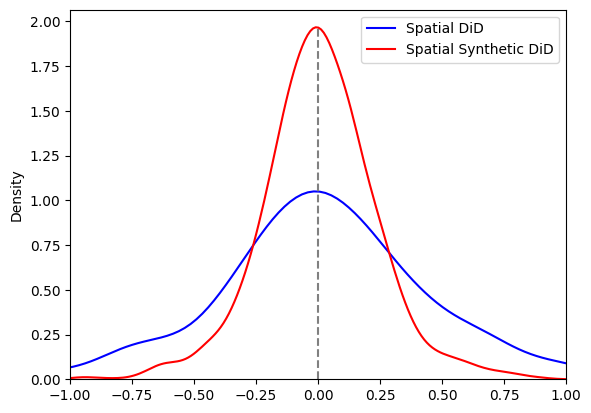

In [16]:
sns.kdeplot(est_AITE_DELGADO, color='blue', label='Spatial DiD')
sns.kdeplot(aite_SSDID, color='red', label='Spatial Synthetic DiD')
plt.xlim(-1,1)
plt.axvline(x=0, ymax=0.95,linestyle='--', color='gray')
#plt.title('Bias for the AITE')
plt.legend()
#plt.savefig('./Results/aite_bias.jpg', dpi=300);